In [2]:
# imports
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import math 
import random 
#from copy import deepcopy
from random import random

In [3]:
# plotting 
# Pictures 1x10
def plotPictures(trained_Weight, safeto, row, col, save=False):
    s_im =[]
    for label in range(trained_Weight.shape[0]):
        im =  np.transpose(np.reshape(trained_Weight[label, :], (3, 32,32)), (1,2,0))
        im = (im - im.min()) / (im.max() - im.min())
        s_im.append(im)

    fig = plt.figure(figsize=(10., 10.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(row, col),  # creates 1x10 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, s_im):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
    if save:
        plt.savefig(safeto)
    plt.show()

# plot all graphs
def plotResults(costs_train, losses_train, accs_train, costs_validate, losses_validate, accs_validate, safeto, save=False):
    # plotting costs
    plt.plot(costs_train, label = "training")
    plt.plot(costs_validate, label = "validation")
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.suptitle('Cost')
    plt.legend()
    if save:
        plt.savefig('Result_Pics/'+safeto+'cost.png')
    plt.show()  
    
    plt.plot(losses_train, label = "training")
    plt.plot(losses_validate, label = "validation")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.suptitle('Loss')
    plt.legend()
    if save:
        plt.savefig('Result_Pics/'+safeto+'loss.png')
    plt.show()  
    
    # plotting accuracy
    plt.plot(accs_train, label = 'training')
    plt.plot(accs_validate, label = 'validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.suptitle('Accuracy')
    plt.legend()
    if save:
        plt.savefig('Result_Pics/'+safeto+'acc.png')
    plt.show()

In [26]:
class Network:
    
    def __init__(self, m, k, d, num_layer, lam):
        self.m_nodes = m
        self.d_dim = d
        self.K = k
        self.lam = lam
        self.X_images_train = None
        self.Y_onehot_train = None
        self.y_labels_train = None
        self.X_images_validate = None
        self.Y_onehot_validate = None
        self.y_labels_validate = None
        self.X_images_test = None
        self.Y_onehot_test = None
        self.y_labels_test = None
        self.W =  [None] * num_layer
        self.b =  [None] * num_layer

    
    def loadBatch(self,filename):
        matdata = sio.loadmat(filename)
        X_images = np.matrix(matdata['data']).astype(float)
        y_labels = np.array(matdata['labels'])
        onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
        Y_onehot = onehot_encoder.fit_transform(y_labels).astype(int)
        return X_images.T, Y_onehot.T, y_labels.T  # convert to (dxn)
    
    def setData(self, filename_train, filename_validate, filename_test):
        if filename_train != None:
            self.X_images_train, self.Y_onehot_train, self.y_labels_train =  self.loadBatch(filename_train)
            self.d_dim = self.X_images_train.shape[0]
        if filename_validate != None:
            self.X_images_validate, self.Y_onehot_validate, self.y_labels_validate =  self.loadBatch(filename_validate)
        if filename_test != None:
            self.X_images_test, self.Y_onehot_test, self.y_labels_test =  self.loadBatch(filename_test)
            
    def setMoreData(self, numbers_train, train_size, filename_test):
        for setnum in range(numbers_train):
            path = 'Dataset/cifar-10-batches-mat/data_batch_'+str(setnum+1)+'.mat'
            (X_images_current,Y_onehot_current,y_labels_current)= self.loadBatch(path)
            if setnum == 0:
                X_images_all = X_images_current
                Y_onehot_all = Y_onehot_current
                y_labels_all = y_labels_current
            else:
                X_images_all = np.append(X_images_all, X_images_current, 1)
                Y_onehot_all = np.append(Y_onehot_all, Y_onehot_current, 1)
                y_labels_all = np.append(y_labels_all, y_labels_current, 1)
        # split into train and validate
        self.X_images_train = X_images_all[:, 0:train_size]
        self.X_images_validate = X_images_all[:, train_size:]
        self.Y_onehot_train = Y_onehot_all[:, 0:train_size]
        self.Y_onehot_validate = Y_onehot_all[:, train_size:]
        self.y_labels_train = y_labels_all[:, 0:train_size]
        self.y_labels_validate = y_labels_all[:, train_size:]
        self.X_images_test, self.Y_onehot_test, self.y_labels_test = self.loadBatch('Dataset/cifar-10-batches-mat/test_batch.mat')
            
    def standardize(self, X):
        mean_X = X.mean(axis=1)
        std_X = X.std(axis=1) 
        return (X - mean_X) / std_X

    def initialize(self, key, mean, std, w_dim, w_num, b_dim):
        np.random.seed(0)
        self.W[key] = np.random.normal(mean, std, (w_dim, w_num))
        self.b[key] = np.zeros((b_dim, 1))
        
    def evaluateClassifier(self, X, W, b):        
        S1 = np.dot(W[0],X)+b[0]
        H = np.maximum(0,S1)
        S2 = np.dot(W[1],H)+b[1]
        P = self.softmax(S2)
        return P, H

    def softmax(self,scores):
        return np.exp(scores)/np.sum(np.exp(scores), axis=0)
    
    def computeCost(self, X, Y, W, b):  
        loss = np.sum(self.lossCrossEntropy(X, Y, W, b))/X.shape[1] 
        sum_W = 0
        sum_W +=  np.sum([np.sum(np.square(W[i])) for i in range(len(W))]) 
        regularization = self.lam * sum_W
        J =  loss + regularization 
        return J, loss
    
    def lossCrossEntropy(self, X, Y, W, b):
        P, _ = self.evaluateClassifier(X, W, b)
        Y = np.reshape(Y, (P.shape))
        #loss = - np.log(np.multiply(Y, P).sum(axis=0))
        loss = - np.sum(np.multiply(Y,np.log(P))) # check this:  - np.sum(Y*np.log(P))
        return loss
    
    def computeGradients(self, X_batch, Y, W, b):
        N = X_batch.shape[1]
        grad_W =  [None] * len(W)
        grad_b =  [None] * len(b)
        
        # forward pass
        P, H = self.evaluateClassifier(X_batch, W, b)
        Y = np.reshape(Y, ( P.shape))
        
        # backward pass
        G_batch = -(Y-P) #(10, 10000)
        ones =  np.full((N,1), 1)
        
        grad_W[1] =  1/N * G_batch * H.T + 2 * self.lam * W[1] #(10,50) 
        grad_b[1] = 1/N * G_batch * ones # (10x1)
        
        G_batch = W[1].T * G_batch #(50,10000)
        G_batch = np.multiply(G_batch, np.where(H > 0, 1, 0))
        
        grad_W[0] = 1/N * G_batch * X_batch.T + 2 * self.lam * W[0]
        grad_b[0] = 1/N * G_batch * ones
        return grad_W, grad_b
                 
        
    def computeGradsNumSlow(self, X, Y, W, b, h):
        """ Converted from matlab code """
        grad_W =  [None] * len(W)
        grad_b =  [None] * len(b)

        for j in range(len(b)):
            grad_b[j] = np.zeros(b[j].shape)
            for i in range(b[j].shape[0]):
                #b_try = np.array(b)
                b_try = b.copy()
                b_try[j][i] -= h
                c1, _ = self.computeCost(X, Y, W, b_try)
                
                #b_try = b.copy() 
                #b_try = deepcopy(b)
                b_try[j][i] += 2*h
                c2, _ = self.computeCost(X, Y, W, b_try)
                
                grad_b[j][i] = (c2-c1) / (2*h)
                
                b_try[j][i] -= h  #restore variable

            
        for j in range(len(W)):
            grad_W[j] = np.zeros(W[j].shape)
            for i in range(W[j].shape[0]):
                for k in range (W[j].shape[1]):
                    W_try = W.copy()
                    W_try[j][i,k] -= h
                    c1, _ = self.computeCost(X, Y, W_try, b)
                    
                    #W_try = W.copy()
                    #W_try = deepcopy(W)
                    W_try[j][i,k] += 2*h
                    c2, _ = self.computeCost(X, Y, W_try, b)
                    grad_W[j][i,k] = (c2-c1) / (2*h)
                    
                    W_try[j][i,k] -= h # restore
                    
        return grad_W, grad_b
    
    def computeRelativeError(self, ga ,gn ,eps):
        return np.absolute(np.subtract(ga, gn))/np.maximum(np.add(np.absolute(ga), np.absolute(gn)), np.full(ga.shape, eps))
    
    def computeAccuracy(self, X, y, W, b):
        P, _ = self.evaluateClassifier(X,W,b)
        pred = np.argmax(P, axis=0)
        acc =  np.count_nonzero(pred == y) / X[1].size
        return acc
    
    def generateMiniBatches(self, n_batch, X, Y, permute):
        n = X[1].size 
        X_batches = []
        Y_batches = []
        if permute:
            #X_sh, Y_sh = shuffle(X.T, Y.T) #causes memory error
            shuff_indx = np.random.permutation(X.shape[1])
            X = X[:, shuff_indx]
            Y = Y[:, shuff_indx]
        for j in range(int(n/n_batch)):
            j_start = j*n_batch 
            j_end = (j+1)*n_batch 

            X_batch = X[:, j_start:j_end]
            Y_batch = Y[:, j_start:j_end]

            X_batches.append(X_batch)
            Y_batches.append(Y_batch)

        return X_batches, Y_batches


    def miniBatchGD(self, X, Y, y, X_validate, Y_validate, y_validate,  W, b, n_batch, eta_min, eta_max, n_epochs, permute, ns, cycle):
        costs_train = []
        losses_train = []
        accs_train = []
        costs_validate = []
        losses_validate= []
        accs_validate  = []
        etas = []

        # compute cost -> print and save it  
        cost_train, loss_train =self.computeCost(X, Y, W, b)
        costs_train.append(cost_train)
        losses_train.append(loss_train)
        cost_validate, loss_validate =self.computeCost(X_validate, Y_validate, W, b)
        costs_validate.append(cost_validate)
        losses_validate.append(loss_validate)

        # compute acc -> print and save it 
        accs_train.append(self.computeAccuracy(X, y, W, b))
        acc_validate = self.computeAccuracy(X_validate, y_validate, W, b)
        accs_validate.append(acc_validate)

        # assignment 1: bonus 1b
        acc_best = acc_validate
        n_best = 0
        
        
        # define stepsize
        #k = random.randint(2,8)
        #n = X.shape[1]
        #ns = k * math.floor(n/n_batch)
        t = 0
        

        if not permute:
            X_batches, Y_batches = self.generateMiniBatches(n_batch, X, Y, permute)
        for epoch in range(n_epochs): #iterate over epoch
            if permute:  # shuffle training data for every epoch
                X_batches, Y_batches = self.generateMiniBatches(n_batch, X, Y, permute)
            
            # 3 cyclical learning rates
            '''
            eta_min: minimum learning rate
            eta_max: maximum learning rate
            eta_t: learning rate at t th update step
            cycle time: 2ns 
            ns: stepsize
            t = 2*l*ns: eta_t = eta_min
            t = (2*l+1)*ns: eta_t = eta_max
            l = 0,1,.. --> epoch
            rule f thumb: ns = k floor(n/n_batch), 
            k: int between 2 and 8
            n: total number of training examples
            n_batch: number of examples in a batch
            '''
            # iterate over mini-batches
            if cycle:
                for idx, X_batch in enumerate(X_batches, start=0):
                    Y_batch = Y_batches[idx]

                    if t == 0: # first cycle
                        l = 0
                        eta_t = eta_min
                    elif t % (2*ns) == 0: # next cycle
                        l += 1

                    if t >= (2*l*ns) and t <= (2*l+1)*ns:
                        eta_t = eta_min + (t-2*l*ns)/ns * (eta_max-eta_min)
                        #print("increase", (t-2*l*ns)/ns * (eta_max-eta_min))
                    elif t >= (2*l+1)*ns and t <= 2*(l+1)*ns:
                        eta_t = eta_max - (t-(2*l+1)*ns)/ns * (eta_max-eta_min)
                        #print("dcrease", t)

                    # save eta for plotting
                    etas.append(eta_t)             

                    # compute gradients for batch
                    grad_W_ana, grad_b_ana = self.computeGradients(X_batch, Y_batch, W,b) 
                        # adjust W,b by eta
                    for i in range(len(W)):
                        W[i] -= eta_t*grad_W_ana[i]
                        b[i] -= eta_t*grad_b_ana[i]

                    t += 1
                    #print("t", t)
                else:
                    # compute gradients for batch
                    grad_W_ana, grad_b_ana = self.computeGradients(X_batch, Y_batch, W,b) 
                        # adjust W,b by eta
                    for i in range(len(W)):
                        W[i] -= eta_min*grad_W_ana[i]
                        b[i] -= eta_min*grad_b_ana[i]
                
                #if t%1 == 0:
            cost_train, loss_train =self.computeCost(X, Y, W, b)
            costs_train.append(cost_train)
            losses_train.append(loss_train)
            cost_validate, loss_validate =self.computeCost(X_validate, Y_validate, W, b)
            costs_validate.append(cost_validate)
            losses_validate.append(loss_validate)

            acc_train = self.computeAccuracy(X, y, W, b)
            accs_train.append(acc_train)
            acc_validate = self.computeAccuracy(X_validate, y_validate, W, b)
            accs_validate.append(acc_validate)

            print("epoch {0} \n cost_train: {1} \n cost_validate: {2} \n accuracy_train: {3} \n accuracy_validate: {4} \n".format(epoch, cost_train, cost_validate, acc_train, acc_validate))

            if acc_validate > acc_best: # bonus 1b
                W_best = W.copy()
                n_best = epoch
                acc_best = acc_validate

        return costs_train, losses_train, accs_train, costs_validate, losses_validate, accs_validate, W, W_best, n_best, etas


In [27]:
# initialize the network
m = 50
k = 10
d = 3072
num_layer = 2
lam = 0.01

net = Network(m,k,d, num_layer, lam)

# load the data
net.setData('Dataset/cifar-10-batches-mat/data_batch_1.mat',
            'Dataset/cifar-10-batches-mat/data_batch_2.mat', 
            'Dataset/cifar-10-batches-mat/test_batch.mat')
        
#net.setMoreData( 5, 45000, 'Dataset/cifar-10-batches-mat/test_batch.mat')
# standardize X values
net.X_images_train = net.standardize(net.X_images_train)
net.X_images_validate = net.standardize(net.X_images_validate)
net.X_images_test = net.standardize(net.X_images_test)

# matrix W1 and W2 have size m x d and K x m respectively and the vectors b1 and b2 have sizes m x 1 and K x 1.
net.initialize(0, 0, 1/math.sqrt(net.d_dim), net.m_nodes, net.d_dim, net.m_nodes)
net.initialize(1, 0, 1/math.sqrt(net.m_nodes), net.K, net.m_nodes, net.K)


In [10]:
print(net.X_images_train.shape, net.X_images_validate.shape, net.X_images_test .shape )

(3072, 10000) (3072, 10000) (3072, 10000)


In [19]:

# 1 test basic functions
#P,H = net.evaluateClassifier(net.X_images_train, net.W, net.b)
#print(P.shape)
#J = net.computeCost(net.X_images_train, net.Y_onehot_train, net.W, net.b)
#print(J)

# initialize the network
m = 50
k = 10
d = 3072
num_layer = 2
lam = 0.01

net = Network(m,k,d, num_layer, lam)

# load the data
#net.setData('Dataset/cifar-10-batches-mat/data_batch_1.mat',
            #'Dataset/cifar-10-batches-mat/data_batch_2.mat', 
            #'Dataset/cifar-10-batches-mat/test_batch.mat')
        
net.setMoreData( 5, 45000, 'Dataset/cifar-10-batches-mat/test_batch.mat')
# standardize X values
net.X_images_train = net.standardize(net.X_images_train)
net.X_images_validate = net.standardize(net.X_images_validate)
net.X_images_test = net.standardize(net.X_images_test)

# matrix W1 and W2 have size m x d and K x m respectively and the vectors b1 and b2 have sizes m x 1 and K x 1.
net.initialize(0, 0, 1/math.sqrt(net.d_dim), net.m_nodes, net.d_dim, net.m_nodes)
net.initialize(1, 0, 1/math.sqrt(net.m_nodes), net.K, net.m_nodes, net.K)

# 2 Testing gradients num and analyt

W_grad, b_grad = net.computeGradsNumSlow(net.X_images_train[:, 0:1], net.Y_onehot_train[:, 0:1], net.W, net.b, 1e-5)
W_grad_ana, b_grad_ana = net.computeGradients(net.X_images_train[:, 0:1], net.Y_onehot_train[:, 0:1], net.W, net.b)

print(W_grad_ana[0].shape, W_grad_ana[1].shape, b_grad_ana[0].shape, b_grad_ana[1].shape)
print(W_grad[0].shape, W_grad[1].shape, b_grad[0].shape, b_grad[1].shape)

#print(W_grad_ana[1][0])
#print(W_grad[1][0])

relW1 = net.computeRelativeError(b_grad_ana[1], b_grad[1], 1e-6)
print("relative error: ",np.max(relW1))

relW1 = net.computeRelativeError(W_grad_ana[0], W_grad[0], 1e-6)
print("relative error: ",np.max(relW1))

relW2 = net.computeRelativeError(W_grad_ana[1], W_grad[1], 1e-6)
print("relative error: ",np.max(relW2))

relb1 = net.computeRelativeError(b_grad_ana[0], b_grad[0], 1e-6)
print("relative error: ",np.max(relb1))

relb2 = net.computeRelativeError(b_grad_ana[1], b_grad[1], 1e-6)
print("relative error: ",np.max(relb2))


(50, 3072) (10, 50) (50, 1) (10, 1)
(50, 3072) (10, 50) (50, 1) (10, 1)
relative error:  1.573218141344005e-10


'\n# 2 Overtrain\ncosts_train, accs_train, costs_validate, accs_validate, W_trained, W_best, n_best = net.miniBatchGD( net.X_images_train[:, 0:100], net.Y_onehot_train[:, 0:100], net.y_labels_train[:, 0:100],                                                                                                net.X_images_validate[:, 0:100], net.Y_onehot_validate[:, 0:100], net.y_labels_validate[:, 0:100],\n                                                                                       net.W, net.b,  100, 0.01, 200, False)\n'

In [28]:

# 2 Overtrain
costs_train, accs_train, costs_validate, accs_validate, W_trained, W_best, n_best = net.miniBatchGD( net.X_images_train[:, 0:100], net.Y_onehot_train[:, 0:100], net.y_labels_train[:, 0:100],                                                                                                net.X_images_validate[:, 0:100], net.Y_onehot_validate[:, 0:100], net.y_labels_validate[:, 0:100],
                                                                                       net.W, net.b,  100, 0.01, 0.01, 200, False, 0, False)


epoch 0 
 cost_train: 3.0590857110464627 
 cost_validate: 3.1992873810742317 
 accuracy_train: 0.14 
 accuracy_validate: 0.09 

epoch 1 
 cost_train: 3.0590857110464627 
 cost_validate: 3.1992873810742317 
 accuracy_train: 0.14 
 accuracy_validate: 0.09 

epoch 2 
 cost_train: 3.0590857110464627 
 cost_validate: 3.1992873810742317 
 accuracy_train: 0.14 
 accuracy_validate: 0.09 

epoch 3 
 cost_train: 3.0590857110464627 
 cost_validate: 3.1992873810742317 
 accuracy_train: 0.14 
 accuracy_validate: 0.09 

epoch 4 
 cost_train: 3.0590857110464627 
 cost_validate: 3.1992873810742317 
 accuracy_train: 0.14 
 accuracy_validate: 0.09 

epoch 5 
 cost_train: 3.0590857110464627 
 cost_validate: 3.1992873810742317 
 accuracy_train: 0.14 
 accuracy_validate: 0.09 

epoch 6 
 cost_train: 3.0590857110464627 
 cost_validate: 3.1992873810742317 
 accuracy_train: 0.14 
 accuracy_validate: 0.09 

epoch 7 
 cost_train: 3.0590857110464627 
 cost_validate: 3.1992873810742317 
 accuracy_train: 0.14 
 ac

UnboundLocalError: local variable 'W_best' referenced before assignment

In [ ]:
# 3 Train your network with cyclical learning rates
eta_min = 1e-5
eta_max = 1e-1
ns = 800 # stepsize
n_batches = 100 # batch size
cycles = 3
epochs = int((ns*2)/n_batches *cycles)
setup = "threecycle_print_each_epoch"

costs_train,losses_train, accs_train, costs_validate, losses_validate, accs_validate, W_trained, W_best, n_best, etas = net.miniBatchGD( net.X_images_train, net.Y_onehot_train, net.y_labels_train,
                                                net.X_images_validate, net.Y_onehot_validate, net.y_labels_validate, 
                                                net.W, net.b, n_batches, eta_min, eta_max, epochs, False, ns)
print(net.computeAccuracy(net.X_images_test, net.y_labels_test, net.W, net.b))
plotResults(costs_train, losses_train, accs_train, costs_validate, losses_validate, accs_validate, setup, True)

In [ ]:
#4 croas search
# initialize the network
m = 50
k = 10
d = 3072
num_layer = 2
#lam = 0

# 3 Train your network with cyclical learning rates
eta_min = 1e-5
eta_max = 1e-1
n_batches = 100 # batch size
cycles = 2

setup = "threecycle_print_each_epoch"
lam_min = -5
lam_max = -1
lam = 10**lam_min + (lam_max - lam_min)* random()
new_lam = lam_min
#print("ns & epochs",ns, epochs)
i= 0
while lam <= 10**lam_max:
#while i <= 3:
    net = Network(m,k,d, num_layer, lam)
    # load the data
    net.setMoreData( 5, 45000, 'Dataset/cifar-10-batches-mat/test_batch.mat')
    # standardize X values
    net.X_images_train = net.standardize(net.X_images_train)
    net.X_images_validate = net.standardize(net.X_images_validate)
    net.X_images_test = net.standardize(net.X_images_test)

    # matrix W1 and W2 have size m x d and K x m respectively and the vectors b1 and b2 have sizes m x 1 and K x 1.
    net.initialize(0, 0, 1/math.sqrt(net.d_dim), net.m_nodes, net.d_dim, net.m_nodes)
    net.initialize(1, 0, 1/math.sqrt(net.m_nodes), net.K, net.m_nodes, net.K)
    
    ns = 2* math.floor(net.X_images_train.shape[1]/n_batches) # stepsize
    epochs = int((ns*2)/n_batches *cycles)
    
    print("lambda ", net.lam)
    costs_train,losses_train, accs_train, costs_validate, losses_validate, accs_validate, W_trained, W_best, n_best, etas = net.miniBatchGD( net.X_images_train, net.Y_onehot_train, net.y_labels_train,
                                                    net.X_images_validate, net.Y_onehot_validate, net.y_labels_validate, 
                                                    net.W, net.b, n_batches, eta_min, eta_max, epochs, False, ns)
    print(net.computeAccuracy(net.X_images_test, net.y_labels_test, net.W, net.b))
    #plotResults(costs_train, losses_train, accs_train, costs_validate, losses_validate, accs_validate, setup, True)
    #new_lam = lam_min + (lam_max - lam_min)* random()
    new_lam += 1
    lam = 10**new_lam
    i +=1

lambda  0.0012412730489630387
epoch 0 
 cost_train: 1.7037392874780437 
 cost_validate: 1.7484338473816619 
 accuracy_train: 0.4253111111111111 
 accuracy_validate: 0.409 

epoch 1 
 cost_train: 1.6301165798170418 
 cost_validate: 1.6839299172108624 
 accuracy_train: 0.44193333333333334 
 accuracy_validate: 0.4218 

epoch 2 
 cost_train: 1.4640320049583664 
 cost_validate: 1.5571350528034413 
 accuracy_train: 0.5088666666666667 
 accuracy_validate: 0.4834 

epoch 3 
 cost_train: 1.365134089375589 
 cost_validate: 1.4817560845367064 
 accuracy_train: 0.5513777777777777 
 accuracy_validate: 0.5102 

epoch 4 
 cost_train: 1.431171490014181 
 cost_validate: 1.5570993898655678 
 accuracy_train: 0.5221111111111111 
 accuracy_validate: 0.4856 

epoch 5 
 cost_train: 1.5191407732466893 
 cost_validate: 1.6349411242887093 
 accuracy_train: 0.4858 
 accuracy_validate: 0.4462 

epoch 6 
 cost_train: 1.38074174024797 
 cost_validate: 1.5304563639494115 
 accuracy_train: 0.5442444444444444 
 accura

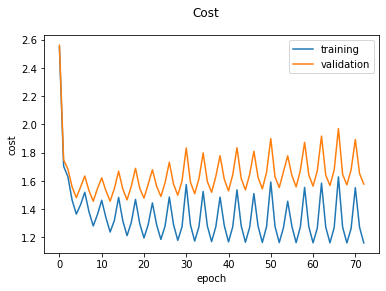

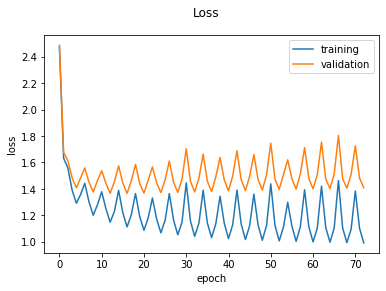

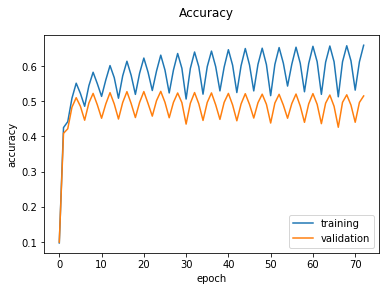

In [5]:
# train with a goof parameter found before
#4 croas search
# initialize the network
m = 50
k = 10
d = 3072
num_layer = 2
lam = 0.0012412730489630387

# 3 Train your network with cyclical learning rates
eta_min = 1e-5
eta_max = 1e-1
n_batches = 100 # batch size
cycles = 4

setup = "threecycle_print_each_epoch"

net = Network(m,k,d, num_layer, lam)
# load the data
net.setMoreData( 5, 45000, 'Dataset/cifar-10-batches-mat/test_batch.mat')
# standardize X values
net.X_images_train = net.standardize(net.X_images_train)
net.X_images_validate = net.standardize(net.X_images_validate)
net.X_images_test = net.standardize(net.X_images_test)

# matrix W1 and W2 have size m x d and K x m respectively and the vectors b1 and b2 have sizes m x 1 and K x 1.
net.initialize(0, 0, 1/math.sqrt(net.d_dim), net.m_nodes, net.d_dim, net.m_nodes)
net.initialize(1, 0, 1/math.sqrt(net.m_nodes), net.K, net.m_nodes, net.K)

ns = 2* math.floor(net.X_images_train.shape[1]/n_batches) # stepsize
epochs = int((ns*2)/n_batches *cycles)

print("lambda ", net.lam)
costs_train,losses_train, accs_train, costs_validate, losses_validate, accs_validate, W_trained, W_best, n_best, etas = net.miniBatchGD( net.X_images_train, net.Y_onehot_train, net.y_labels_train,
                                                net.X_images_validate, net.Y_onehot_validate, net.y_labels_validate, 
                                                net.W, net.b, n_batches, eta_min, eta_max, epochs, False, ns)
print(net.computeAccuracy(net.X_images_test, net.y_labels_test, net.W, net.b))
plotResults(costs_train, losses_train, accs_train, costs_validate, losses_validate, accs_validate, setup, True)

